Train to detect person, car, and bike

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import os
import cv2
import random

# Define dataset paths
DATADIR = "./new_data/"
ANNOTATIONS_FILE = 'train_labels_8_bit.txt'  # CSV file with bounding boxes and labels
CATEGORIES = ["car", "person", "bike"]  # Object categories


In [2]:
# # Load annotations
# df = pd.read_csv(ANNOTATIONS_FILE, sep=" ", names=["image_file", "class_id", "x_min", "y_min", "x_max", "y_max"])
# # reduce size of dataframe for testing purposes
# df = df[0:15]

# # make y variables
# y_train = np.array(df[['class_id']]-1)
# y_bboxes = np.array(df[["x_min", "y_min", "x_max", "y_max"]])
# y_train, y_bboxes
# df

In [2]:
# creating data
data = []
IMG_SIZE = 150

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()
random.shuffle(data)
len(data)

48774

In [4]:
# make X and y
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

y = np.array(y)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
X = X.astype('float32') / 255.0


In [ ]:
# Split the data into training and testing sets (80% train, 20% test)
X_train_og, X_test_og, y_train_og, y_test_og = train_test_split(X, y, test_size=0.2, random_state=77)


X_train = X_train_og[0:20000]
y_train = y_train_og[0:20000]
X_test = X_test_og[0:3000]
y_test = y_test_og[0:3000]

In [11]:
X_test_og.shape

(9755, 150, 150, 1)

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

# Create the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    MaxPooling2D((2, 2)),

    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(CATEGORIES), activation='softmax')
])

model.compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
    

early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    restore_best_weights = True
)

# Print model summary
# model.summary()



Epoch 1/20
488/488 [==============================] - 440s 899ms/step - loss: 0.6299 - accuracy: 0.7349 - val_loss: 0.5721 - val_accuracy: 0.7893
Epoch 2/20
488/488 [==============================] - 431s 883ms/step - loss: 0.4651 - accuracy: 0.8130 - val_loss: 0.3898 - val_accuracy: 0.8457
Epoch 3/20
488/488 [==============================] - 436s 894ms/step - loss: 0.3373 - accuracy: 0.8689 - val_loss: 0.3105 - val_accuracy: 0.8910
Epoch 4/20
488/488 [==============================] - 422s 866ms/step - loss: 0.2665 - accuracy: 0.8989 - val_loss: 0.2947 - val_accuracy: 0.8857
Epoch 5/20
488/488 [==============================] - 424s 870ms/step - loss: 0.2182 - accuracy: 0.9191 - val_loss: 0.2713 - val_accuracy: 0.8967
Epoch 6/20
488/488 [==============================] - 423s 867ms/step - loss: 0.1797 - accuracy: 0.9323 - val_loss: 0.2793 - val_accuracy: 0.9034
Epoch 7/20
488/488 [==============================] - 422s 864ms/step - loss: 0.1453 - accuracy: 0.9469 - val_loss: 0.2726 -

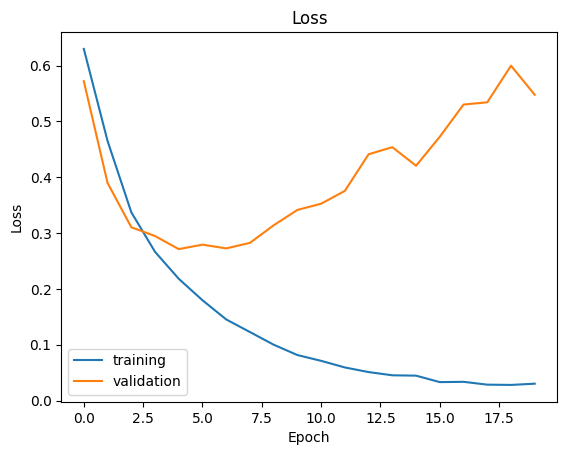

In [17]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2)

plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

# Print the test results
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

305/305 [==============================] - 26s 84ms/step - loss: 0.5359 - accuracy: 0.9132
Test loss: 0.5359151363372803
Test accuracy: 0.913172721862793


In [19]:
model.save('thermal_detection_model.h5')

c:\Users\Owner\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


305/305 [==============================] - 27s 89ms/step


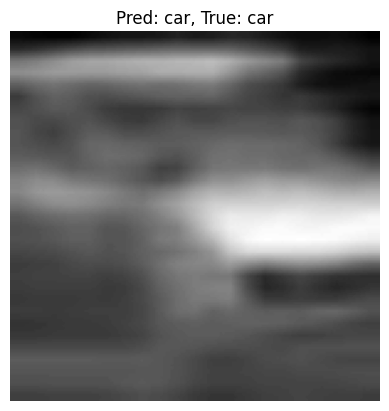

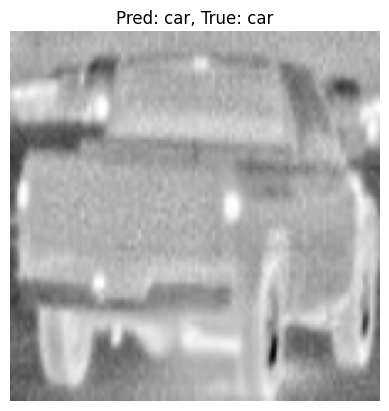

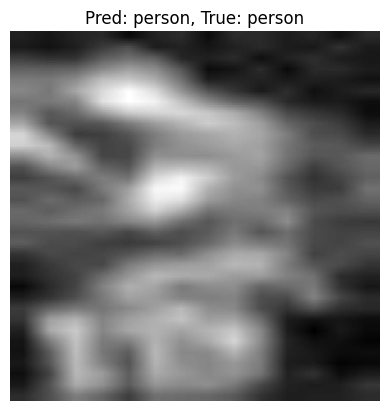

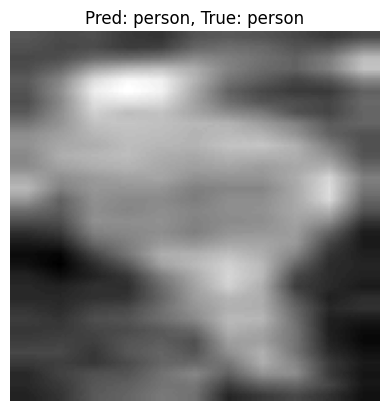

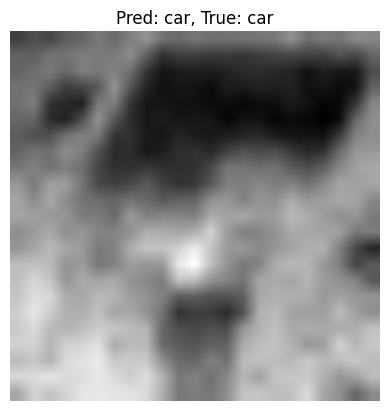

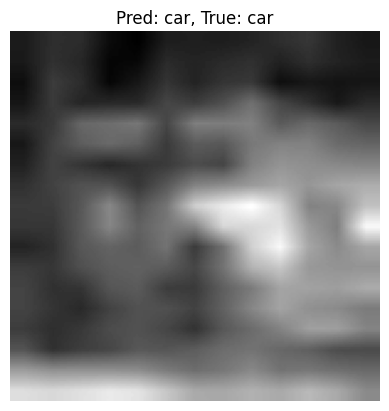

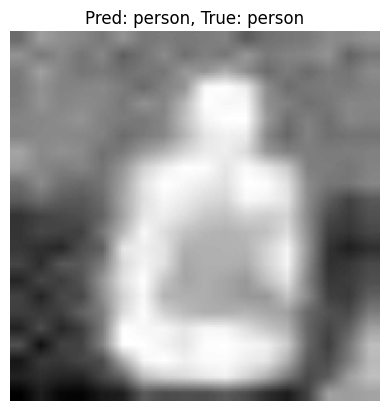

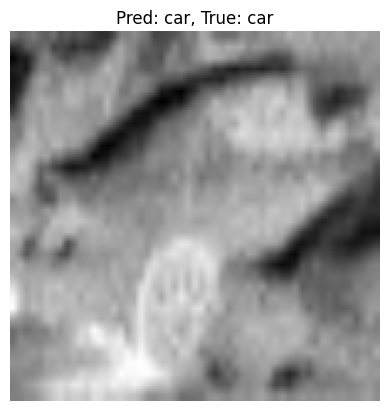

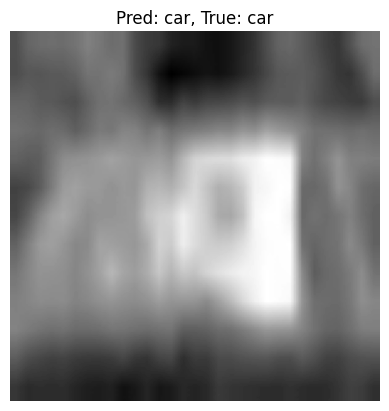

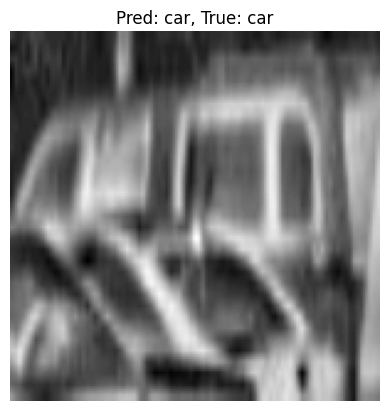

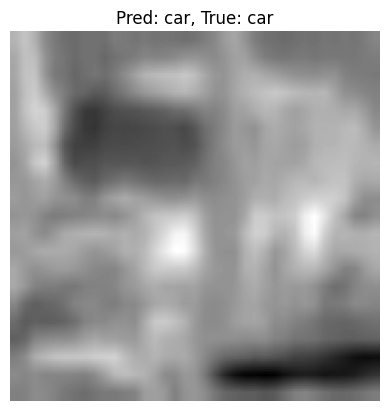

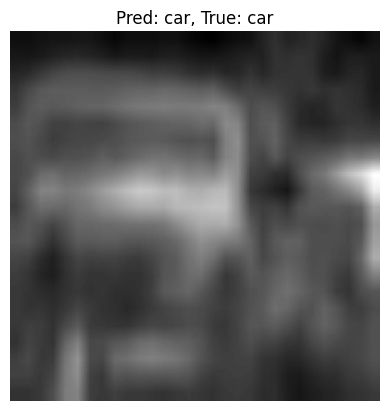

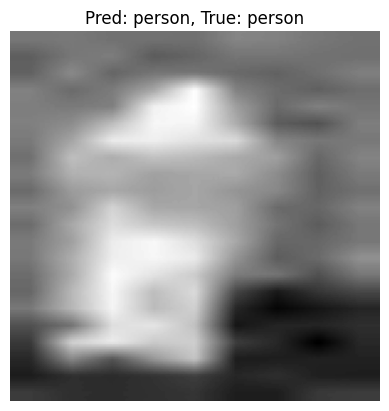

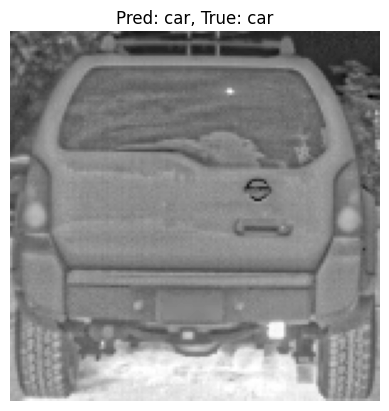

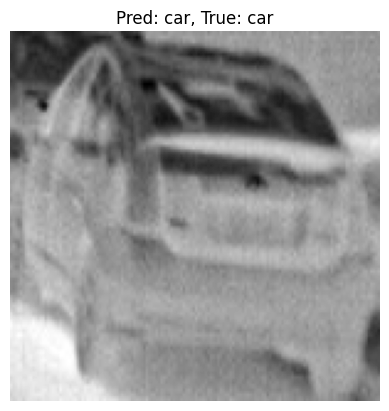

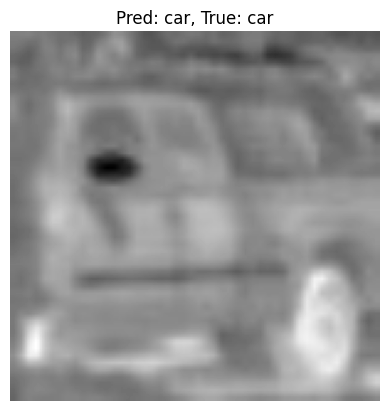

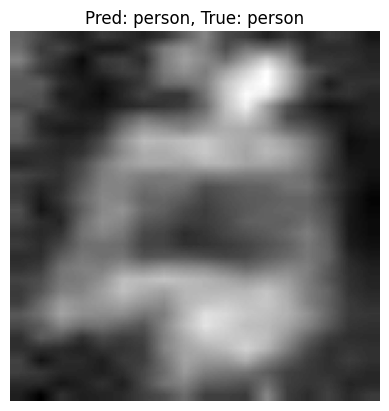

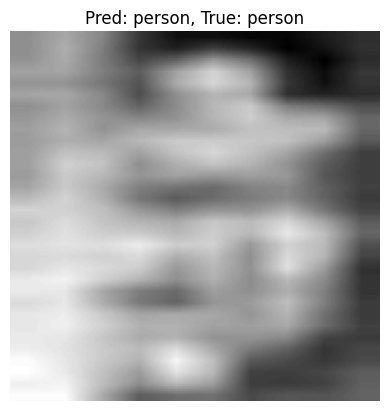

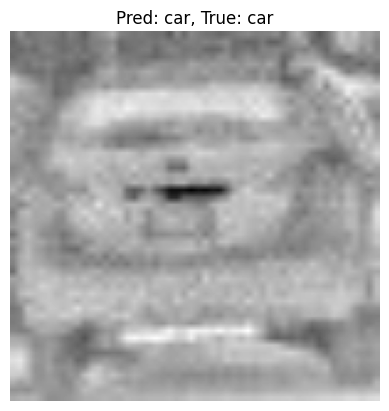

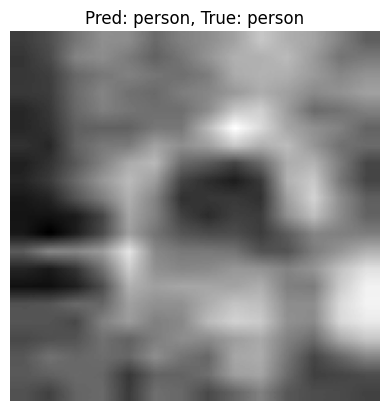

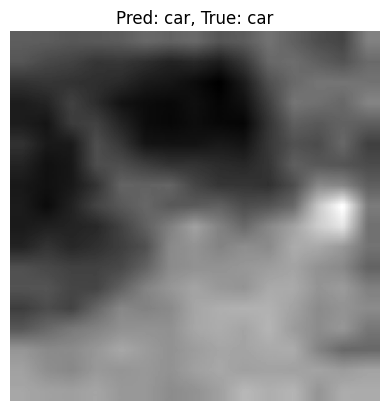

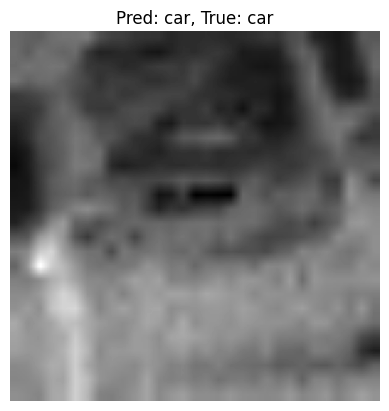

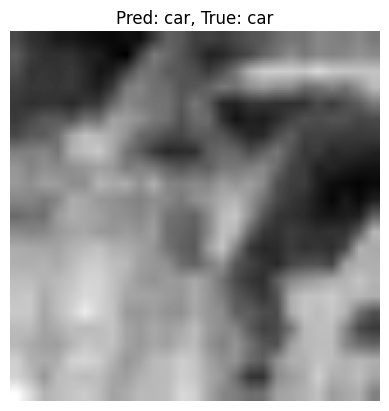

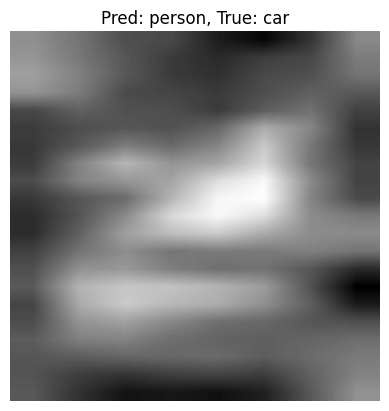

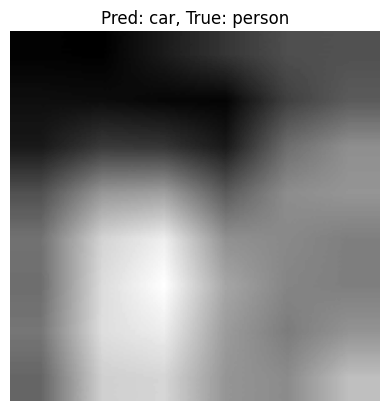

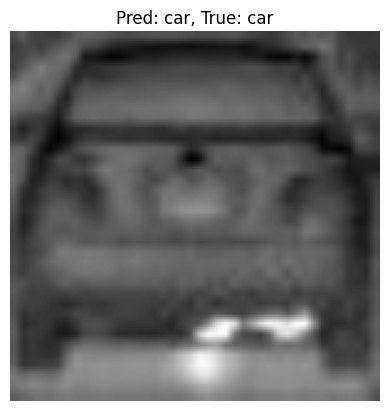

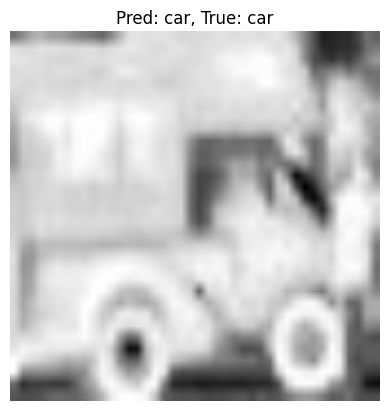

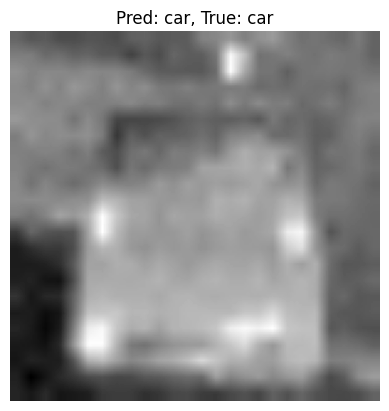

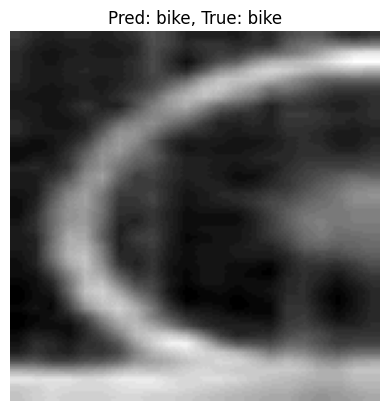

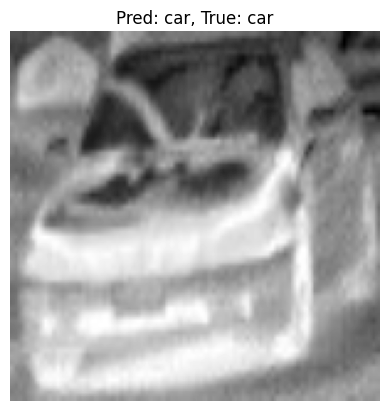

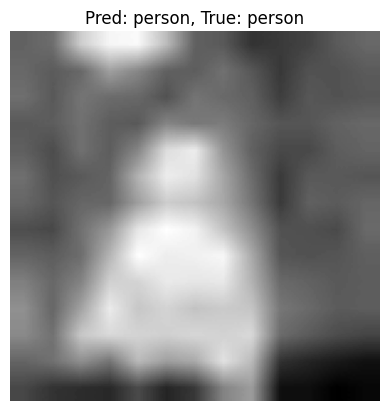

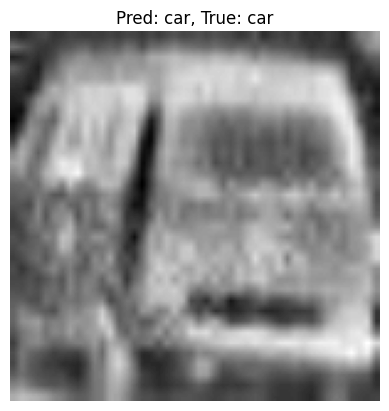

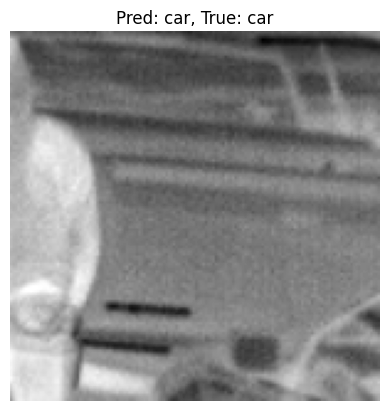

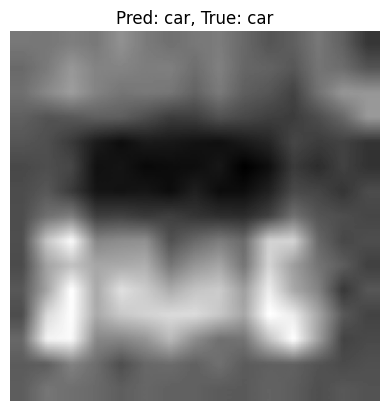

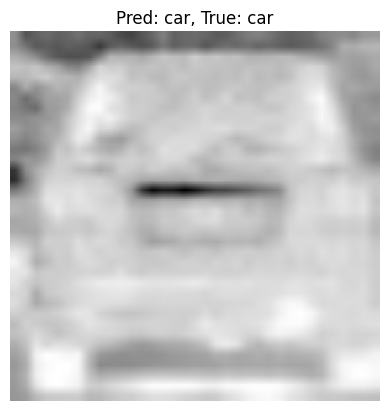

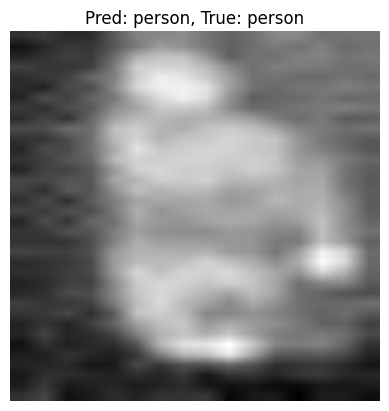

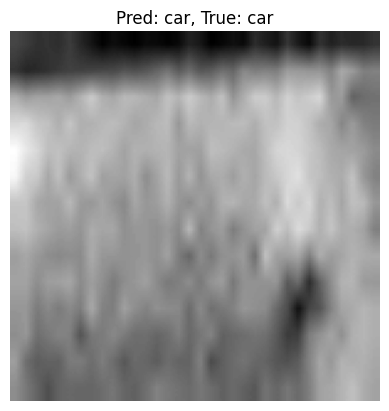

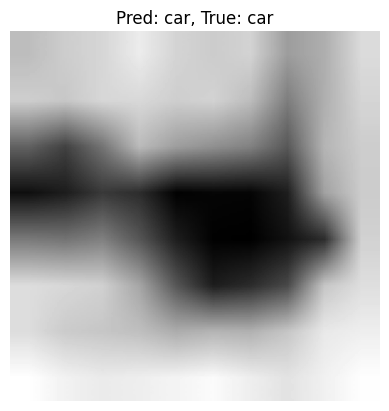

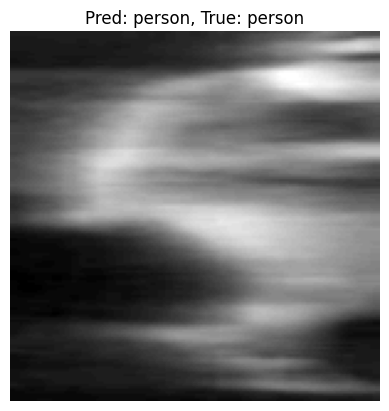

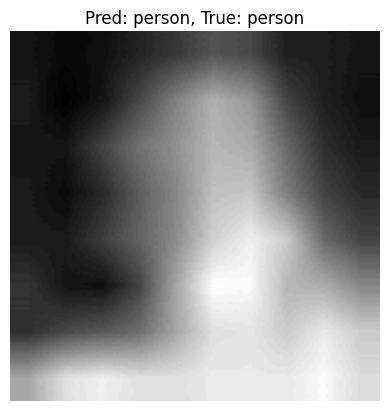

In [24]:
# Get predictions on the test set
y_pred = model.predict(X_test)

# Display some test images with their predicted and actual labels
num_images = 40  # Number of images to display
for i in range(num_images):
    # Get the image, predicted label, and true label
    image = X_test[i].reshape(IMG_SIZE, IMG_SIZE)  # Reshape if needed (depends on your input shape)
    predicted_label = np.argmax(y_pred[i])  # Get the predicted class index
    true_label = y_test[i]  # True label
    
    # Display the image
    plt.imshow(image, cmap='gray')  # Use 'gray' for grayscale images
    plt.title(f"Pred: {CATEGORIES[predicted_label]}, True: {CATEGORIES[true_label]}")
    plt.axis('off')  # Hide axes
    plt.show()